# Portfolio Mathematics: Calculating Risk & Return 
## Learn the Basics of Modern Portfolio Theory (MPT)
### Plus: Sharpe Ratio and How to Choose an Optimal Mix Of Stocks for your Portfolio
### Also: Testing Ray Dalio's All-Weather Portfolio

In this tutorial you'll learn: 
* How to calculate expected risk and standard deviation (risk) for a group of stocks
* How to calculate and interpret risk-adjusted returns using the Sharpe ratio
* How to choose specific companies and their allocations for your portfolio
* To work with classes, functions, and visuals in Python using pandas, yfinance, numpy, matplotlib, and more

#### For previous tutorials, please check:
* [How to Fetch Stock Data](https://github.com/yusifrefae/Jupyter-Projects/blob/main/fetch-stock-data.ipynb)
* [Stock Options Data Analysis](https://github.com/yusifrefae/Jupyter-Projects/blob/main/stock-options-data-analysis.ipynb)
* [Calculate Expected Move using Options](https://github.com/yusifrefae/Jupyter-Projects/blob/main/calculate-expected-move.ipynb)
* [Automating Two-Stage Dividend Growth Model](https://github.com/yusifrefae/Jupyter-Projects/blob/main/two-stage-growth-model.ipynb)
* [Predicting Stock Prices using Multiple Linear Regression](http://localhost:8977/notebooks/7-multiple-linear-regression-tutorial.ipynb)

### Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Create a function to find the risk-free rate of return, which we'll use later in calculating Sharpe Ratio

In [2]:
def rf_rate():
    """Estimate of risk-free rate that uses iShares 0-3 month Treasury dividend yield (Ticker: SGOV)"""
    rate = yf.Ticker('SGOV').info.get('dividendYield')
    return rate / 100    

In [3]:
rf_rate()

0.0435

### Now let's define a simple portfolio to test as we build the class.
We'll do more complex testing at the end after we've built it.

In [4]:
tickers = ['AMZN', 'MSFT', 'GOOGL']
stock_amounts = [200000, 300000, 400000]
cash_reserves = 100000
total_capital = sum(stock_amounts) + cash_reserves

### Let's define a helper function to convert cash amounts to percentage weights
We'll use if statements to handle:
* Non-numeric inputs
* Cases where the total amount is zero

In [5]:
def amounts_to_weights(amounts, total_amount):
    """Convert cash amounts in portfolio of stocks to percentage allocation weights"""
    # Validate amounts as numeric
    for amount in amounts:
        if not isinstance(amount, (int, float)):
            raise ValueError("Amounts must be numeric.")
    
    # Prevent division by zero error
    if abs(total_amount) < 1e-12:
        raise ValueError("Amounts sum to 0 — can't convert to weights.")
        
    return [amount / total_amount for amount in amounts]

In [6]:
stock_weights = amounts_to_weights(stock_amounts, total_capital)
cash_weight = cash_reserves / total_capital
stock_weights + [cash_weight]

[0.2, 0.3, 0.4, 0.1]

In [7]:
for w, ticker, amount in zip(range(0, 3), tickers, stock_amounts):
    print(f'{ticker}: ${amount:.2f}- {stock_weights[w] * 100: .2f}%')
print(f'Cash: ${cash_reserves: .2f} - {cash_weight * 100: .2f}%')
print(f'Total: ${total_capital:.2f}')

AMZN: $200000.00-  20.00%
MSFT: $300000.00-  30.00%
GOOGL: $400000.00-  40.00%
Cash: $ 100000.00 -  10.00%
Total: $1000000.00


### First, define a class with an initialization method that creates a 'Portfolio' object
* Note that we'll treat the cash weight separately, as an absolute weight (10% in this case).
* Later we'll build a helper method to handle different weights of cash and stocks and ensure they sum up to 100%.

In [8]:
class Portfolio:
    """Portfolio class to calculate weighted risk/return metrics."""
    # Initialize portfolio, default cash weight is 0%
    def __init__(self, symbols_in, weights_in, cash_weight_in = 0.0):
        self.symbols = symbols_in
        self.weights = weights_in
        self.cash_weight = cash_weight_in

In [9]:
p = Portfolio(tickers, stock_weights, cash_weight)
print(f'The portfolio contains the following stocks: {p.symbols}')
print(f'The portfolio weights (in order) are: {p.weights}')
print(f'The cash weight of the portfolio is: {p.cash_weight}')
print()
print(f'The portfolio is of type {type(p)}')

The portfolio contains the following stocks: ['AMZN', 'MSFT', 'GOOGL']
The portfolio weights (in order) are: [0.2, 0.3, 0.4]
The cash weight of the portfolio is: 0.1

The portfolio is of type <class '__main__.Portfolio'>


### So far so good. Now let's build that helper method.
We begin with some if statements:
* To ensure weights are numeric
* To prevent duplicate symbols (we could handle these, but let's keep the code simple)
* To ensure the number of symbols matches the number of weights
* To ensure the weights don't sum to zero

We keep the given cash weight absolute (e.g. if we're given 10%, it doesn't rescale, only the stock weights do)

In [10]:
def scale_weights(self):
    """Scale asset weights so that assets sum to (1 - cash_weight).
       Allows negative weights (shorts) and handles numeric validation.
       Raises ValueError on duplicates, length mismatch, or zero-sum weights."""
    # Validate cash_weight as numeric
    if not isinstance(self.cash_weight, (int, float)):
        raise ValueError("Cash weight must be numeric.")
    
    # Check for duplicate symbols
    if len(self.symbols) != len(set(self.symbols)):
        raise ValueError("Duplicate symbols not allowed. Use only unique symbols.")

    # Check that number of weights matches number of symbols
    if len(self.weights) != len(self.symbols):
        raise ValueError("Number of weights must match number symbols.")
########################################################################################
    
    # Set up logic to scale input weights
    sum_w = sum(self.weights)
    target = 1 - self.cash_weight
    
    if abs(sum_w) < 1e-12:
        raise ValueError("Asset weights sum to 0 — can't scale.")
########################################################################################

    # Rescale stock weights, while keeping cash weight aboslute
    scaled_weights = [w * target / sum_w for w in self.weights]

    # Return dataframe of symbols keyed to weights
    return pd.DataFrame({'Symbol': self.symbols + ['Cash Reserves'],
                         'Weight': scaled_weights + [self.cash_weight]})

### Now we'll add the method to the class and test it.

In [11]:
Portfolio.scale_weights = scale_weights

In [12]:
p.scale_weights()

,Symbol,Weight
0,AMZN,0.2
1,MSFT,0.3
2,GOOGL,0.4
3,Cash Reserves,0.1


### It might seem redundant, but this step makes sure we can handle:
* Negative cash weights (e.g. leveraging a portfolio)
* Short positions (e.g. negative asset weights)
* Division by zero errors 
* Scaling weights properly so that total (non-cash) weights sum to 1 - cash_weight
* Returning a clean DataFrame with all asset weights and a final row for 'Cash Reserves'

# Let's calculate expected return. 

### First we make a helper function to scale the returns.
* The first step is to scale the returns using the natural logarithm (LN).
* First we use the dates method to get start and end dates.
* Then we use it to download all the symbols at once.
* This improves speed/performance (for dozens of symbols it can get quite slow otherwise).
* We use NumPy and the shift function to calculate daily LN of returns for each stock.
* We force the returns to be in the same order as the symbols were (just in case they shifted)
* Note that by default the return for cash is 0
* Finally we return the dataframe

In [13]:
def scale_returns(self):
    """Calculate daily natural log of returns for portfolio assets and add a cash column."""    
    # Get close price data for all symbols based on start and end dates
    returns = yf.download(self.symbols, period='max', auto_adjust=True, progress=False)['Close']
    
    # Calculate daily natural log (continuous) returns and drop the first row of NaNs
    returns = np.log(returns / returns.shift(1))
    
    # Reorder dataframe columns to match weights dataframe, add cash reserves columns
    returns =  returns[self.symbols]
    
    # Add cash column after ordering
    returns.loc[:, 'Cash Reserves'] = 0.0
    
    return returns

### It might help to break this out a bit more to see what's happening.

#### Create a compound dataframe by downloading all stock data from yfinance.

In [14]:
returns = yf.download(tickers, period='max', auto_adjust=True, progress=False)['Close']
returns

Ticker,AMZN,GOOGL,MSFT
Date,,,
1986-03-13,NaN,NaN,0.059500
1986-03-14,NaN,NaN,0.061625
1986-03-17,NaN,NaN,0.062688
1986-03-18,NaN,NaN,0.061093
1986-03-19,NaN,NaN,0.060031
...,...,...,...
2025-10-15,215.570007,251.029999,513.429993
2025-10-16,214.470001,251.460007,511.609985
2025-10-17,213.039993,253.300003,513.580017


#### Calculate daily returns using LN and shift functions.

In [15]:
returns = np.log(returns / returns.shift(1))
returns      

Ticker,AMZN,GOOGL,MSFT
Date,,,
1986-03-13,NaN,NaN,NaN
1986-03-14,NaN,NaN,0.035089
1986-03-17,NaN,NaN,0.017103
1986-03-18,NaN,NaN,-0.025760
1986-03-19,NaN,NaN,-0.017543
...,...,...,...
2025-10-15,-0.003797,0.022479,-0.000273
2025-10-16,-0.005116,0.001712,-0.003551
2025-10-17,-0.006690,0.007291,0.003843


#### Forcibly reorder columns if they got out of order (they DID in this case). 
#### Add cash column, which has default return of 0%.

In [16]:
returns = returns[tickers].copy()  # Set as copy to avoid warning message
returns.loc[:, 'Cash Reserves'] = 0.0
returns

Ticker,AMZN,MSFT,GOOGL,Cash Reserves
Date,,,,
1986-03-13,NaN,NaN,NaN,0.0
1986-03-14,NaN,0.035089,NaN,0.0
1986-03-17,NaN,0.017103,NaN,0.0
1986-03-18,NaN,-0.025760,NaN,0.0
1986-03-19,NaN,-0.017543,NaN,0.0
...,...,...,...,...
2025-10-15,-0.003797,-0.000273,0.022479,0.0
2025-10-16,-0.005116,-0.003551,0.001712,0.0
2025-10-17,-0.006690,0.003843,0.007291,0.0


### Putting it all together with one class method call

In [17]:
Portfolio.scale_returns = scale_returns

In [18]:
scaled_Returns = p.scale_returns()
scaled_Returns

Ticker,AMZN,MSFT,GOOGL,Cash Reserves
Date,,,,
1986-03-13,NaN,NaN,NaN,0.0
1986-03-14,NaN,0.035089,NaN,0.0
1986-03-17,NaN,0.017103,NaN,0.0
1986-03-18,NaN,-0.025761,NaN,0.0
1986-03-19,NaN,-0.017543,NaN,0.0
...,...,...,...,...
2025-10-15,-0.003797,-0.000273,0.022479,0.0
2025-10-16,-0.005116,-0.003551,0.001712,0.0
2025-10-17,-0.006690,0.003843,0.007291,0.0


### Let's quickly visualize the returns as histograms to see the probability distributions of daily returns
* The daily returns are approximately normally distributed in a bell-shaped curve, as expected, with a peak around 0%.

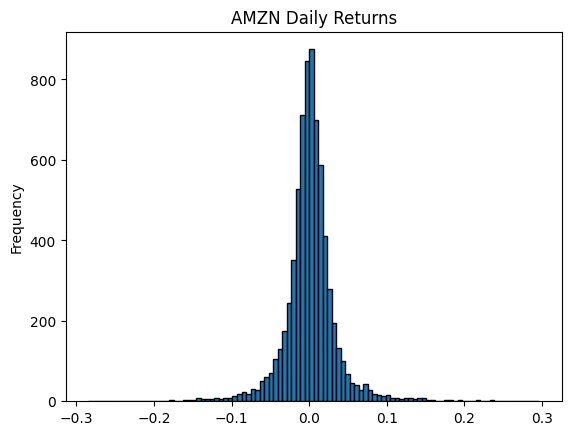

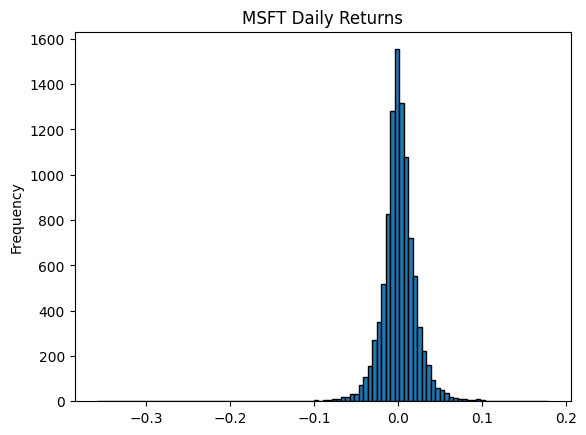

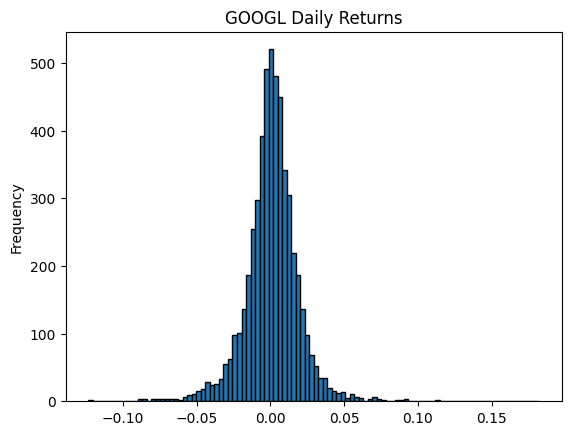

In [19]:
for t in tickers: 
    data = scaled_Returns[t]
    data.plot(kind='hist', 
              bins=100, 
              edgecolor='black', 
              title = t + ' Daily Returns')
    plt.show()

### Voila! We have a neat dataframe with daily returns. We're now ready to calculate expected return and volatility.

In [20]:
def risk_and_return(self):
    """Calculate annualized portfolio risk and expected return using daily log (continuous) returns.
       Returns risk-free rate and sharpe ratio as well."""
    # Get scaled returns dataframe
    returns = self.scale_returns() 
    
    # Create covariance matrix dataframe. Annualize based on number of trading days per year
    cov_matrix = returns.cov() * 252

    # Convert weights from series to numpy array, ensuring order of weights matches order of columns
    weights_array = self.scale_weights().set_index('Symbol')['Weight'].reindex(cov_matrix.columns).fillna(0).to_numpy()

    # Calculate portfolio risk using NumPy dot product
    portfolio_risk = np.sqrt(np.dot(weights_array, np.dot(cov_matrix, weights_array)))

    # Calculate the portfolio's expected return as a weighted average
    portfolio_expected_return = (returns.mean() * 252 * weights_array).sum()

    risk_free_rate = rf_rate()
    
    sharpe_ratio = (portfolio_expected_return - risk_free_rate) / portfolio_risk
    
    return portfolio_expected_return, risk_free_rate, portfolio_risk, sharpe_ratio

### This function does a lot. 
* It calculates the portfolio's risk and expected return.
* It calculates the risk-free rate of return.
* It calculates the portfolio's Sharpe Ratio.
---
# $$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$$
#### * $R_p$: Return of the portfolio  
#### * $R_f$: Return of a risk-free asset (e.g. short-term US Treasury bonds)  
#### * $\sigma_p$: Standard deviation of the portfolio's returns

### Standard Deviation Formula:
## $\sigma = \sqrt{\frac{1}{N - 1} \sum_{i=1}^{N} (x_i - \bar{x})^2}$
- **$\sigma$** — Standard deviation (measure of volatility or dispersion).  
- **$N$** — Number of observations (e.g., trading days).  
- **$x_i$** — Each individual data point (e.g., a daily return).  
- **$\bar{x}$** — Mean (average) of all data points.  
- **$(x_i - \bar{x})^2$** — Squared deviation of each point from the mean.  
- **$\frac{1}{N - 1}$** — Normalization factor (uses *N − 1* for an unbiased sample estimate).


## Calculating Portfolio Risk 
---
#### * **Portfolio risk** (standard deviation) measures the overall volatility of a portfolio's returns.
#### * It considers individual asset risks ($\sigma_i$) and their correlations ($\rho_{ij}$).
#### * It also considers asset weights in the portfolio.

#### For 2 assets:
## $$ \sigma_p = \sqrt{w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12}}$$

#### For 3 assets:
## $$ \sigma_p = \sqrt{w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + w_3^2 \sigma_3^2 + 2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} + 2 w_1 w_3 \sigma_1 \sigma_3\rho_{13} + 2 w_2 w_3 \sigma_2 \sigma_3 \rho_{23}}$$
* The math gets significantly more complex and error-prone from there. 
* The number of terms greatly expands, so we use a covariance matrix to automate the calculations.

## Portfolio Expected Return
---
#### The portfolio expected return is the weighted sum of the expected returns of its assets:
## $$E(R_p) = \sum_i w_i E(R_i)$$

#### - $w_i$ = weight of asset $i$ in the portfolio
#### - $E(R_i)$ = expected return of asset $i$

* We calculate the mean daily return of each asset.
* Then we multiply by 252 (the number of trading days per year) to annualizes the daily return.
* We use the sum product to compute the weighted sum of these annualized returns to get total expected return for the portfolio.

#### For 3 Assets:
## $$E(R_p) = w_1 E(R_1) + w_2 E(R_2) + w_3 E(R_3)$$

* This is basically the sumproduct function in Excel. Much simpler than the risk calculation!

### Phew! Heavy theory. But it's pretty slick in Python. Let's calculate return. The payoff is coming soon...

In [21]:
p.scale_returns()

Ticker,AMZN,MSFT,GOOGL,Cash Reserves
Date,,,,
1986-03-13,NaN,NaN,NaN,0.0
1986-03-14,NaN,0.035089,NaN,0.0
1986-03-17,NaN,0.017103,NaN,0.0
1986-03-18,NaN,-0.025761,NaN,0.0
1986-03-19,NaN,-0.017544,NaN,0.0
...,...,...,...,...
2025-10-15,-0.003797,-0.000273,0.022479,0.0
2025-10-16,-0.005116,-0.003551,0.001712,0.0
2025-10-17,-0.006690,0.003843,0.007291,0.0


In [22]:
p.scale_returns().mean()

Ticker
AMZN             0.001080
MSFT             0.000909
GOOGL            0.000865
Cash Reserves    0.000000
dtype: float64

In [23]:
p.scale_returns().mean() * 252

Ticker
AMZN             0.272203
MSFT             0.229073
GOOGL            0.218057
Cash Reserves    0.000000
dtype: float64

In [24]:
stock_weights + [cash_weight]

[0.2, 0.3, 0.4, 0.1]

In [25]:
portfolio_expected_return = np.dot(p.scale_returns().mean() * 252, stock_weights + [cash_weight])
portfolio_expected_return

np.float64(0.21038523976391027)

### Let's check manually

In [26]:
(0.272203 * 0.2) + (0.229073 * 0.3) + (0.218057 * 0.4) + (0.1 * 0)

0.2103853

#### Basically the same result. The difference is due to rounding. So you see how it works for return, it's very simple.
* Get the daily close price data.
* Calculate the continuously compounded daily returns using natural log (LN).
* Find the average of those daily returns (often thousands of samples per stock!)
* Annualize that average so it's a yearly return, not a daily one.
* Do the sumproduct of the weights based on stock's weight and its annualized return.

### Now. Let's create a covariance matrix.

In [27]:
p.scale_returns().cov()

Ticker,AMZN,MSFT,GOOGL,Cash Reserves
Ticker,,,,
AMZN,0.001189,0.000280,0.000237,0.0
MSFT,0.000280,0.000441,0.000183,0.0
GOOGL,0.000237,0.000183,0.000369,0.0
Cash Reserves,0.000000,0.000000,0.000000,0.0


### This table represents the **covariances** between the returns of each pair of assets.
* Larger values mean the assets tend to move together more.
* Diagonal elements represent the **variance** of each asset.
* Cash has **zero** covariance with any of the stocks.

#### Let's examine the risk formula for 4 assets:
#### $$ 
\sigma_p = \sqrt{
w_1^2 \sigma_1^2 + 
w_2^2 \sigma_2^2 + 
w_3^2 \sigma_3^2 + 
w_4^2 \sigma_4^2 + 
2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} + 
2 w_1 w_3 \sigma_1 \sigma_3 \rho_{13} + 
2 w_1 w_4 \sigma_1 \sigma_4 \rho_{14} + 
2 w_2 w_3 \sigma_2 \sigma_3 \rho_{23} + 
2 w_2 w_4 \sigma_2 \sigma_4 \rho_{24} + 
2 w_3 w_4 \sigma_3 \sigma_4 \rho_{34}
} 
$$

* But the standard deviation for the fourth asset (Cash) is 0.
* Any covariance that includes cash is also 0.
* So all terms involving $\sigma_4$ and $\rho_4$ become 0, and the formula simplifies to the formula for 3 assets:
### $$ 
\sigma_p = \sqrt{
w_1^2 \sigma_1^2 + 
w_2^2 \sigma_2^2 + 
w_3^2 \sigma_3^2 + 
2 w_1 w_2 \sigma_1 \sigma_2 \rho_{12} + 
2 w_1 w_3 \sigma_1 \sigma_3 \rho_{13} + 
2 w_2 w_3 \sigma_2 \sigma_3 \rho_{23}
} 
$$

### Let's calculate manually first and then check it against our NumPy matrix shortcut
Start by calculating standard deviation for each stock's daily returns (it's 0 by default for cash)

In [28]:
p.scale_returns().std()

Ticker
AMZN             0.034483
MSFT             0.020998
GOOGL            0.019221
Cash Reserves    0.000000
dtype: float64

#### Also note the correlation coefficient formula:

The correlation between two assets is calculated by dividing their covariance by the product of their standard deviations:

### $$\rho_{ij} = \frac{\text{cov}(r_i, r_j)}{\sigma_i \sigma_j}$$

### Now let's set up this super messy formula. 

In [29]:
w1 = 0.2
w2 = 0.3
w3 = 0.4

s1 = 0.034483
s2 = 0.020998
s3 = 0.019221

cov12 = 0.000280
cov13 = 0.000237
cov23 = 0.000183

corr12 = cov12 / (s1 * s2)
corr13 = cov13 / (s1 * s3)
corr23 = cov23 / (s2 * s3)

risk1 = np.sqrt(252) * np.sqrt((w1**2 * s1**2) + 
                              (w2**2 * s2**2) + 
                              (w3**2 * s3**2) + 
                              (2*w1*w2*s1*s2*corr12) + 
                              (2*w1*w3*s1*s3*corr13) + 
                              (2*w2*w3*s2*s3*corr23))
risk1

np.float64(0.2568518068321887)

* We multiply by sqrt(252) because we need ANNUALIZED calculations, just like how we annualized returns previously

### Now let's use the linear algebra shortcut: covariance matrix and NumPy dot product.

In [30]:
cov_matrix = p.scale_returns().cov() * 252
weights_array = np.array(p.scale_weights()['Weight'])
risk2 = np.sqrt(np.dot(weights_array, np.dot(cov_matrix, weights_array)))
risk2

np.float64(0.25682666390218245)

#### The only difference is due to rounding. Boom. Our code works perfectly. Let's get the Sharpe Ratio now.

In [31]:
sharpe_ratio = (portfolio_expected_return - rf_rate()) / risk2
sharpe_ratio

np.float64(0.6497971714785497)

### What this means:
* The Sharpe ratio is a measure of **risk-adusted return**.
* It tells you approximately how much return you'll earn for a given level of risk.
* It's easy to earn high returns in the market. But those usually come with **high risk** and greater volatility.
* It's also easy to make **low-risk** investments. However, these might not always optimize for the **highest** returns.
* What we want to maximize is the **risk-adjusted** return.
* In other words: for a given level of risk, we want to maximize the return of the portfolio.
* Stated another way: for a given desired return on the portfolio, we want to miinimize the level of portfolio risk.

### Putting it all together
* We have the inputs to the sharpe ratio formula now.
* Let's bypass all this math with a single function

### Let's add the method to the class and demonstrate.

In [32]:
Portfolio.risk_and_return = risk_and_return

### Define a function to print the portfolio's output stats.

In [33]:
def print_stats(self): 
    p_return, Rf, p_risk, p_sharpe = self.risk_and_return() 
    print(f'Expected Return: {p_return: .4f}')
    print(f'Risk-Free Rate: {Rf: .4f}')
    print(f'Standard Deviation: {p_risk: .4f}')
    print(f'Sharpe Ratio: {p_sharpe: .4f}')

In [34]:
Portfolio.print_stats = print_stats

In [35]:
p.print_stats()

Expected Return:  0.2104
Risk-Free Rate:  0.0435
Standard Deviation:  0.2568
Sharpe Ratio:  0.6498


### Ok, we've accomplished our goal, but soon we'll apply this logic to create cooler things.
For now, let's note:
* The portfolio has an expected return of approximately 21%.
* The standard deviation of returns is about 26%.
* This means some years might see negative returns, while other years returns could approach over 40%.
* The Sharpe Ratio is around 0.65, which is roughly the historical baseline for the S&P 500 (around 0.5).
* However, we want to aim for a GREAT Sharpe Ratio — typically anything above 1.0 is considered excellent.


### Let's visualize our portfolio's weights

In [36]:
def plot_weights(self):
    """Take scaled weights dataframe and plot allocation percentages with horizontal bar graph"""
    weights_df = self.scale_weights()
    fig, ax = plt.subplots(figsize=(5, 3)) 
    ax.barh(weights_df['Symbol'], 
            weights_df['Weight'], 
            color='blue', 
            height=0.5)  # Bar thickness
    
    ax.set_xlabel('Weight (%)')
    ax.set_title('Portfolio Weights by Symbol')
    plt.tight_layout()
    plt.show()

In [37]:
Portfolio.plot_weights = plot_weights

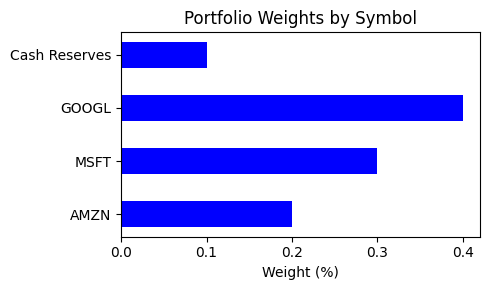

In [38]:
p.plot_weights()

### Very cool! Let's quickly add a lot more symbols and weight them equally.

In [39]:
tickers2 = ['AMZN', 'MSFT', 'GOOGL', 'CPB', 'GIS', 'PFE', 'O', 'MCD', 'SBUX', 'CVX']
weights = [1/len(tickers2)] * len(tickers2) 
p2 = Portfolio(tickers2, weights, 0.05)
p2.print_stats()

Expected Return:  0.1457
Risk-Free Rate:  0.0435
Standard Deviation:  0.1741
Sharpe Ratio:  0.5869


### Notice that the **Sharpe Ratio has decreased**! Oh no! 
* This is because we added a bunch of 'boring' non-tech companies.
* The expected return went down from 21% to approximately 15%.
* The volatility also reduced from 26% to around 17%, which is good.
* But our risk-adjusted return is now lower. No bueno.
### We'll examine stock selection methods in a moment, and learn how to **increase** Sharpe Ratio. Stick with it.

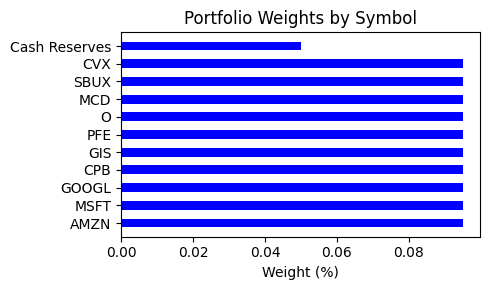

In [40]:
p2.plot_weights()

#### Notice that the cash weight remained 5% (the absolute amount we specified) while the rest of the stocks were allocated equally.

### Now let's turn to stock selection. How can we choose stocks to increase the portfolio's Sharpe Ratio?
* As you **diversify** a portfolio by adding more stocks to it, it's possible to increase the risk-adjusted return.
* This occurs if the assets have less volatility and/or correlation with one another.
* By adding stocks with high ratios to the portfolio we can achieve a much higher ratio than each stock could achieve on its own.
* It's possible to diversify away idiosynchratic risk associated with individual securities.
* But it's NOT possible to reduce systemic, market risk through diversification.
* For example one cannot diversify to protect against recessions, wars, covid, black swan events, etc. 

### Let's define a function to examine and filter the Sharpe Ratios for multiple stocks.
* This works similar to the previous 'risk_and_return' function, so let's not rehash the details of the code.
* Thankfully it **does** skip the linear alegbra!  :-)
* Anyhow, the magic is in the **application** of these principles, not the coding itself!
* First we download all the stock data and put it in a dataframe
* To speed up progress we limit the number of API calls.
* Then we calculate daily returns using the natural log and annualize them.
* Next we find the daily standard deviation of returns and annualize those.
* We grab the risk-free rate and put it in a variable.
* Finally we calculate the sharpe ratio and return a dataframe with the outputs, with symbols as keys.

In [41]:
def get_sharpe_ratios(symbols):
    # Build a DataFrame of each ticker’s full closing-price history, aligned by date.
    data = yf.download(symbols, period="max", auto_adjust=True, progress=True)["Close"]
    
    # Build a dataframe of returns based on data using nautral logarithm
    returns = np.log(data.values[1:] / data.values[:-1])
    returns = pd.DataFrame(returns, index=data.index[1:], columns=data.columns)

    # Drop NaNs per column and calculate annualized return and 
    # standard deviation for each column based on 252 trading days per day    
    annualized_returns = returns.mean(skipna=True) * 252
    annualized_volatility = returns.std(skipna=True) * np.sqrt(252)

    # Calculate risk-free rate for use in Sharpe Ratio formula
    risk_free_rate = rf_rate()

    # Calculate sharpe ratios 
    sharpe_ratios = (annualized_returns - risk_free_rate) / annualized_volatility
    
    summary = pd.DataFrame({"annual_return": annualized_returns,
                            "annual_volatility": annualized_volatility,
                            "sharpe_ratio": sharpe_ratios})
    return summary

In [42]:
mySymbols = ["AMGN", "APH", "ADI", "AON", "APA", "APO", "AAPL", "AMAT", "APP", "APTV", "ACGL"]

df = get_sharpe_ratios(mySymbols)
df

[*********************100%***********************]  11 of 11 completed


,annual_return,annual_volatility,sharpe_ratio
Ticker,,,
AAPL,0.175857,0.446135,0.296674
ACGL,0.121929,0.288439,0.271910
ADI,0.138361,0.432835,0.219162
AMAT,0.177380,0.478477,0.279804
AMGN,0.168922,0.375214,0.334269
AON,0.126924,0.277633,0.300484
APA,0.054767,0.444489,0.025348
APH,0.203345,0.353738,0.451875
APO,0.197574,0.361356,0.426376


### Now let's calculate sharpe ratios for every stock in the S&P 500!

In [43]:
sp500 = [
    "MMM", "AOS", "ABT", "ABBV", "ACN", "ADBE", "AMD", "AES", "AFL", "A", "APD", "ABNB", "AKAM", "ALB", "ARE", "ALGN",
    "ALLE", "LNT", "ALL", "GOOGL", "GOOG", "MO", "AMZN", "AMCR", "AEE", "AEP", "AXP", "AIG", "AMT", "AWK", "AMP", "AME",
    "AMGN", "APH", "ADI", "AON", "APA", "APO", "AAPL", "AMAT", "APP", "APTV", "ACGL", "ADM", "ANET", "AJG", "AIZ", "T", 
    "ATO", "ADSK", "ADP", "AZO", "AVB", "AVY", "AXON", "BKR", "BALL", "BAC", "BAX", "BDX", "BRK-B", "BBY", "TECH", "BIIB", 
    "BLK", "BX", "XYZ", "BK", "BA", "BKNG", "BSX", "BMY", "AVGO", "BR", "BRO", "BF-B", "BLDR", "BG", "BXP", "CHRW", "CDNS", 
    "CPT", "CPB", "COF", "CAH", "KMX", "CCL", "CARR", "CAT", "CBOE", "CBRE", "CDW", "COR", "CNC", "CNP", "CF", "CRL", "SCHW", 
    "CHTR", "CVX", "CMG", "CB", "CHD", "CI", "CINF", "CTAS", "CSCO", "C", "CFG", "CLX", "CME", "CMS", "KO", "CTSH", "COIN", 
    "CL", "CMCSA", "CAG", "COP", "ED", "STZ", "CEG", "COO", "CPRT", "GLW", "CPAY", "CTVA", "CSGP", "COST", "CTRA", "CRWD", 
    "CCI", "CSX", "CMI", "CVS", "DHR", "DRI", "DDOG", "DVA", "DAY", "DECK", "DE", "DELL", "DAL", "DVN", "DXCM", "FANG", "DLR", 
    "DG", "DLTR", "D", "DPZ", "DASH", "DOV", "DOW", "DHI", "DTE", "DUK", "DD", "EMN", "ETN", "EBAY", "ECL", "EIX", "EW", 
    "EA", "ELV", "EME", "EMR", "ETR", "EOG", "EPAM", "EQT", "EFX", "EQIX", "EQR", "ERIE", "ESS", "EL", "EG", "EVRG", "ES", 
    "EXC", "EXE", "EXPE", "EXPD", "EXR", "XOM", "FFIV", "FDS", "FICO", "FAST", "FRT", "FDX", "FIS", "FITB", "FSLR", "FE", 
    "FI", "F", "FTNT", "FTV", "FOXA", "FOX", "BEN", "FCX", "GRMN", "IT", "GE", "GEHC", "GEV", "GEN", "GNRC", "GD", "GIS", 
    "GM", "GPC", "GILD", "GPN", "GL", "GDDY", "GS", "HAL", "HIG", "HAS", "HCA", "DOC", "HSIC", "HSY", "HPE", "HLT", "HOLX", 
    "HD", "HON", "HRL", "HST", "HWM", "HPQ", "HUBB", "HUM", "HBAN", "HII", "IBM", "IEX", "IDXX", "ITW", "INCY", "IR", "PODD", 
    "INTC", "IBKR", "ICE", "IFF", "IP", "IPG", "INTU", "ISRG", "IVZ", "INVH", "IQV", "IRM", "JBHT", "JBL", "JKHY", "J", "JNJ", 
    "JCI", "JPM", "K", "KVUE", "KDP", "KEY", "KEYS", "KMB", "KIM", "KMI", "KKR", "KLAC", "KHC", "KR", "LHX", "LH", "LRCX", 
    "LW", "LVS", "LDOS", "LEN", "LII", "LLY", "LIN", "LYV", "LKQ", "LMT", "L", "LOW", "LULU", "LYB", "MTB", "MPC", "MAR", 
    "MMC", "MLM", "MAS", "MA", "MTCH", "MKC", "MCD", "MCK", "MDT", "MRK", "META", "MET", "MTD", "MGM", "MCHP", "MU", "MSFT", 
    "MAA", "MRNA", "MHK", "MOH", "TAP", "MDLZ", "MPWR", "MNST", "MCO", "MS", "MOS", "MSI", "MSCI", "NDAQ", "NTAP", "NFLX", 
    "NEM", "NWSA", "NWS", "NEE", "NKE", "NI", "NDSN", "NSC", "NTRS", "NOC", "NCLH", "NRG", "NUE", "NVDA", "NVR", "NXPI", 
    "ORLY", "OXY", "ODFL", "OMC", "ON", "OKE", "ORCL", "OTIS", "PCAR", "PKG", "PLTR", "PANW", "PSKY", "PH", "PAYX", "PAYC", 
    "PYPL", "PNR", "PEP", "PFE", "PCG", "PM", "PSX", "PNW", "PNC", "POOL", "PPG", "PPL", "PFG", "PG", "PGR", "PLD", "PRU", 
    "PEG", "PTC", "PSA", "PHM", "PWR", "QCOM", "DGX", "RL", "RJF", "RTX", "O", "REG", "REGN", "RF", "RSG", "RMD", "RVTY", 
    "HOOD", "ROK", "ROL", "ROP", "ROST", "RCL", "SPGI", "CRM", "SBAC", "SLB", "STX", "SRE", "NOW", "SHW", "SPG", "SWKS", 
    "SJM", "SW", "SNA", "SOLV", "SO", "LUV", "SWK", "SBUX", "STT", "STLD", "STE", "SYK", "SMCI", "SYF", "SNPS", "SYY", 
    "TMUS", "TROW", "TTWO", "TPR", "TRGP", "TGT", "TEL", "TDY", "TER", "TSLA", "TXN", "TPL", "TXT", "TMO", "TJX", "TKO", 
    "TTD", "TSCO", "TT", "TDG", "TRV", "TRMB", "TFC", "TYL", "TSN", "USB", "UBER", "UDR", "ULTA", "UNP", "UAL", "UPS", 
    "URI", "UNH", "UHS", "VLO", "VTR", "VLTO", "VRSN", "VRSK", "VZ", "VRTX", "VTRS", "VICI", "V", "VST", "VMC", "WRB", 
    "GWW", "WAB", "WMT", "DIS", "WBD", "WM", "WAT", "WEC", "WFC", "WELL", "WST", "WDC", "WY", "WSM", "WMB", "WTW", "WDAY", 
    "WYNN", "XEL", "XYL", "YUM", "ZBRA", "ZBH", "ZTS"
]

In [ ]:
df = get_sharpe_ratios(sp500)
df

[**                     5%                       ]  26 of 503 completed

### Let's filter a bit to see companies with a sharpe ratio of 0.4 or higher.

In [ ]:
df_high = df[df["sharpe_ratio"] >= 0.4]
df_high

### That's still a lot. Let's filter to see companies that also have volatility less than 0.3.

In [ ]:
df2 = df[(df["sharpe_ratio"] >= 0.4) & (df['annual_volatility'] <= 0.3)]
df2

### Let's put the symbols in a list and make it a portfolio.

In [ ]:
tickers3 = df2.index.tolist()
tickers3

In [ ]:
p3 = Portfolio(tickers3, [1/len(tickers3)] * len(tickers3), 0.1)
p3.print_stats()

### Sharpe Ratio of 0.76 is 0.10 higher than our first portfolio!
Recapping:
* Portfolio 1: 21% return, 26% risk, 0.65 sharpe ratio
* Portfolio 2: 15% return, 17% risk, 0.59 sharpe ratio
* Portfolio 3: 15% return, 13% risk, 0.76 sharpe ratio
* Portfolio 3 has almost the same return as Portfolio 2, but with **less risk**!

### Let's try another test case.

In [ ]:
df_test = df[(df["sharpe_ratio"] >= 0.5)]
df_test

In [ ]:
tickers4 = df_test.index.tolist()
p4 = Portfolio(tickers4, [1/len(tickers4)] * len(tickers4), 0.1)
p4.print_stats()

### Very cool. Shape ratio of 1.14, above the target of 1.0. 
* Our initial portfolio had 21% return with 26% volatility.
* This portfolio has **less volatility** (23%) with **a higher return** (over 30%)

### If we reduce cash to 0% allocation, we get an even higher ratio. 

In [ ]:
p4 = Portfolio(tickers4, [1/len(tickers4)] * len(tickers4), 0.0)
p4.print_stats()

### Some important caveats and limitations:
* This is all based on **historical** data. The past does NOT equal the future. Use with caution.
* The Sharpe Ratio tends to skew towards favoring higher-risk stocks.
    * For example, the previous portfolio included PLTR, a **very** risky stock.
    * Including it definitely increases our portfolio's Sharpe Ratio, since its annualized return was 58%.
    * However, its volatility is also sky-high at 70%+.
    * Including such a risky asset in a portfolio requires some common-sense, not just number-crunching.

### Let's test Ray Dalio's "All Weather" portfolio.
* Ray Dalio is widely regarded one of the most successful hedge fund investors in history.
* His philosophy is based on this type of analysis and he focuses on asset allocation and correlation above all else.
* The idea is to reduce risk even during recessions and downturns so that returns are smoother.
* He was featured in Tony Robbins' book "Money: Master the Game."
* In the book he laid out his 'secret formula' of asset allocation.
* This portfolio is supposed to produce results in 'all weather' (e.g. all economic seasons, even during the storms, thus the name)
* The simplified (unlevered) portfolio is 30% stocks, 40% long-term bonds, 15% short-term bonds, 7.5% gold, 7.5% commodities.

### Let's use ETFs to test Ray's portfolio.
* SPY tracks the S&P 500 (stocks).
* TLT tracks 20+ year US Treasury bonds (long-term bonds).
* IEI tracks 3-7 year US Treasuriy bonds (short/mid-term bonds).
* GLD tracks gold.
* GSG tracks multiple commodities, including oil.

In [ ]:
allweather_etfs = ['SPY', 'TLT', 'IEI', 'GLD', 'GSG']
allweather_weights = [0.3, 0.4, 0.15, .075, 0.075] 
allweather_p = Portfolio(allweather_etfs, allweather_weights, 0.0)
allweather_p.print_stats()

### Sharpe Ratio of 0.15. Very poor performance.
* However, look at the risk. Less than 8% volatility. It's VERY low! Performance is very stable and smooth.
* If the risk-free rate was lower, the sharpe ratio would be much higher.
* In no way does this result mean we should dismiss Ray's investment philosophy!
* He built a multi-billion dollar empire using similar asset allocations.
* This test result speaks more to the limitations of Modern Portfolio
* It's unfair to dismiss the validity of the allweather portfolio based on this analysis alone.

In [ ]:
allweather_p.plot_weights()

# Full Code For Reference

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

###########################################################################################################
def rf_rate():
    """Estimate of risk-free rate that uses iShares 0-3 month Treasury dividend yield (Ticker: SGOV)"""
    rate = yf.Ticker('SGOV').info.get('dividendYield')
    return rate / 100    
    
###########################################################################################################
def amounts_to_weights(amounts, total_amount):
    """Convert cash amounts in portfolio of stocks to percentage allocation weights"""
    # Validate amounts as numeric
    for amount in amounts:
        if not isinstance(amount, (int, float)):
            raise ValueError("Amounts must be numeric.")
    
    # Prevent division by zero error
    if abs(total_amount) < 1e-12:
        raise ValueError("Amounts sum to 0 — can't convert to weights.")
        
    return [amount / total_amount for amount in amounts]

###########################################################################################################
def get_sharpe_ratios(symbols):
    # Build a DataFrame of each ticker’s full closing-price history, aligned by date.
    data = yf.download(symbols, period="max", auto_adjust=True, progress=True)["Close"]
    
    # Build a dataframe of returns based on data using nautral logarithm
    returns = np.log(data.values[1:] / data.values[:-1])
    returns = pd.DataFrame(returns, index=data.index[1:], columns=data.columns)

    # Drop NaNs per column and calculate annualized return and 
    # standard deviation for each column based on 252 trading days per day    
    annualized_returns = returns.mean(skipna=True) * 252
    annualized_volatility = returns.std(skipna=True) * np.sqrt(252)

    # Calculate risk-free rate for use in Sharpe Ratio formula
    risk_free_rate = rf_rate()

    # Calculate sharpe ratios 
    sharpe_ratios = (annualized_returns - risk_free_rate) / annualized_volatility
    
    summary = pd.DataFrame({"annual_return": annualized_returns,
                            "annual_volatility": annualized_volatility,
                            "sharpe_ratio": sharpe_ratios})
    return summary

###########################################################################################################  
def wgt_avg_market_caps(symbols):
    """Return list of weighted averages according to market capitalization of symbols.
       Handle missing or zero market caps by skipping them, and avoids duplicate API calls."""                
    # Create object for multiple tickers
    tickers_obj = yf.Tickers(symbols)
    
    # Extract market cap for each symbol, default to 0 if no market cap exists
    mkt_caps = []
    for symbol in symbols:
        mkt_cap = tickers_obj.tickers[symbol].info.get('marketCap', 0) or 0
        mkt_caps.append(mkt_cap)
    
    # Check that that total of market caps is not zero
    if sum(mkt_caps) == 0:
        raise ValueError("All market caps are zero or unavailable.")
    
    # Compute market-cap weighted proportions
    weights = [mkt_cap / sum(mkt_caps) for mkt_cap in mkt_caps]
    return weights    

##########################################################################################################
class Portfolio:
    """Portfolio class to calculate weighted risk/return metrics."""
    # Initialize portfolio, default cash weight is 0%
    def __init__(self, symbols_in, weights_in, cash_weight_in = 0.0):
        self.symbols = symbols_in
        self.weights = weights_in
        self.cash_weight = cash_weight_in
        
##########################################################################################################
    def scale_weights(self):
        """Scale asset weights so that assets sum to (1 - cash_weight).
           Allows negative weights (shorts) and handles numeric validation.
           Raises ValueError on duplicates, length mismatch, or zero-sum weights."""
        # Validate cash_weight as numeric
        if not isinstance(self.cash_weight, (int, float)):
            raise ValueError("Cash weight must be numeric.")
        
        # Check for duplicate symbols
        if len(self.symbols) != len(set(self.symbols)):
            raise ValueError("Duplicate symbols not allowed. Use only unique symbols.")
    
        # Check that number of weights matches number of symbols
        if len(self.weights) != len(self.symbols):
            raise ValueError("Number of weights must match number symbols.")
    
        # Set up logic to scale input weights
        sum_w = sum(self.weights)
        target = 1 - self.cash_weight
        
        if abs(sum_w) < 1e-12:
            raise ValueError("Asset weights sum to 0 — can't scale.")
    
        # Rescale stock weights, while keeping cash weight aboslute
        scaled_weights = [w * target / sum_w for w in self.weights]
    
        # Return dataframe of symbols keyed to weights
        return pd.DataFrame({'Symbol': self.symbols + ['Cash Reserves'],
                             'Weight': scaled_weights + [self.cash_weight]})
        
##########################################################################################################
    def scale_returns(self):
        """Calculate daily natural log of returns for portfolio assets and add a cash column."""    
        # Get close price data for all symbols based on start and end dates
        returns = yf.download(self.symbols, period='max', auto_adjust=True, progress=False)['Close']
        
        # Calculate daily natural log (continuous) returns and drop the first row of NaNs
        returns = np.log(returns / returns.shift(1))
        
        # Reorder dataframe columns to match weights dataframe, add cash reserves columns
        returns =  returns[self.symbols]
        
        # Add cash column after ordering
        returns.loc[:, 'Cash Reserves'] = 0.0
        
        return returns

##########################################################################################################
    def risk_and_return(self):
        """Calculate annualized portfolio risk and expected return using daily log (continuous) returns.
           Returns risk-free rate and sharpe ratio as well."""
        # Get scaled returns dataframe
        returns = self.scale_returns() 
        
        # Create covariance matrix dataframe. Annualize based on number of trading days per year
        cov_matrix = returns.cov() * 252
    
        # Convert weights from series to numpy array, ensuring order of weights matches order of columns
        weights_array = self.scale_weights().set_index('Symbol')['Weight'].reindex(cov_matrix.columns).fillna(0).to_numpy()
    
        # Calculate portfolio risk using NumPy dot product
        portfolio_risk = np.sqrt(np.dot(weights_array, np.dot(cov_matrix, weights_array)))
    
        # Calculate the portfolio's expected return as a weighted average
        portfolio_expected_return = (returns.mean() * 252 * weights_array).sum()
    
        risk_free_rate = rf_rate()
        
        sharpe_ratio = (portfolio_expected_return - risk_free_rate) / portfolio_risk
        
        return portfolio_expected_return, risk_free_rate, portfolio_risk, sharpe_ratio
        
##########################################################################################################
    def print_stats(self): 
        """Print key portfolio statistics"""
        p_return, Rf, p_risk, p_sharpe = self.risk_and_return() 
        print(f'Expected Return: {p_return: .4f}')
        print(f'Risk-Free Rate: {Rf: .4f}')
        print(f'Standard Deviation: {p_risk: .4f}')
        print(f'Sharpe Ratio: {p_sharpe: .4f}')
        
##########################################################################################################
    def plot_weights(self):
        """Take scaled weights dataframe and plot allocation percentages with horizontal bar graph"""
        weights_df = self.scale_weights()
        fig, ax = plt.subplots(figsize=(5, 3)) 
        ax.barh(weights_df['Symbol'], 
                weights_df['Weight'], 
                color='blue', 
                height=0.5)  # Bar thickness
        
        ax.set_xlabel('Weight (%)')
        ax.set_title('Portfolio Weights by Symbol')
        plt.tight_layout()
        plt.show()

In [ ]:
new_p = Portfolio(['NVDA', 'PLTR', 'AMZN', 'MSFT', 'GOOGL'], [0.2, 0.2, 0.15, 0.15, 0.3], 0)
new_p.print_stats()

In [ ]:
new_p.plot_weights()

## Author: Yusif Refae, MBA
#### Let's work together: <a href = "https://www.linkedin.com/in/yusifrefae/">Message me on LinkedIn!</a>